# IQ Cloud Test (1Q + 2Q Multiplexed)

`iq_cloud` 실험/분석 모듈 사용 예제입니다.

목표:
- 1Q/2Q에서 `SINGLE_SHOT + INTEGRATION` 데이터 획득
- shared-covariance Gaussian + Bayes decision boundary 기반 분석
- fidelity / confusion matrix / separation / bootstrap CI 확인
        


In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.deactivate()

fuck
LOADED: ./qpu_parameters/20260211-0052_2q_qst


# CONNECTION


In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=True)
#session.disconnect()

[2026.02.11 15:20:46.593] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.11 15:20:46.595] INFO    VERSION: laboneq 25.10.3
[2026.02.11 15:20:46.595] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.11 15:20:46.597] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.11 15:20:46.598] INFO    Configuring the device setup
[2026.02.11 15:20:46.600] INFO    The device setup is configured


In [3]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from experiments import iq_cloud


def unwrap_output(obj):
    cur = obj
    for _ in range(16):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        return cur
    return cur


def _is_reference_like(obj):
    return obj is not None and obj.__class__.__name__ == "Reference"


def _contains_reference(obj, depth=0, max_depth=10):
    if depth > max_depth:
        return False
    cur = unwrap_output(obj)
    if _is_reference_like(cur):
        return True
    if isinstance(cur, dict):
        return any(_contains_reference(v, depth + 1, max_depth) for v in cur.values())
    if isinstance(cur, (list, tuple)):
        return any(_contains_reference(v, depth + 1, max_depth) for v in cur)
    return False


def _to_float(x):
    x = unwrap_output(x)
    if _is_reference_like(x):
        raise TypeError(
            "Reference value is not materialized. "
            "Use extract_analysis_output(workflow_result) first."
        )
    return float(x)


def _iter_tasks(obj):
    tasks = getattr(obj, "tasks", None)
    if tasks is None:
        return []
    try:
        return list(tasks)
    except Exception:
        return []


def _find_analysis_workflow_result(node, depth=0, max_depth=12):
    if node is None or depth > max_depth:
        return None

    tasks = _iter_tasks(node)
    if tasks:
        names = {getattr(t, 'name', '') for t in tasks}
        if 'bootstrap_metrics' in names:
            return node

        for t in tasks:
            found = _find_analysis_workflow_result(t, depth + 1, max_depth)
            if found is not None:
                return found
            found = _find_analysis_workflow_result(getattr(t, 'output', None), depth + 1, max_depth)
            if found is not None:
                return found

    out = getattr(node, 'output', None)
    if out is not None and out is not node:
        found = _find_analysis_workflow_result(out, depth + 1, max_depth)
        if found is not None:
            return found

    return None


def _task_output(task_view, key):
    try:
        return unwrap_output(task_view[key].output)
    except Exception:
        return None


def _assemble_from_analysis_tasks(analysis_wf_result):
    tasks = getattr(analysis_wf_result, 'tasks', None)
    if tasks is None:
        return None

    assembled = {
        'decision_model': _task_output(tasks, 'fit_decision_models'),
        'thresholds': _task_output(tasks, 'extract_thresholds'),
        'confusion_matrices': _task_output(tasks, 'select_confusion_matrices'),
        'assignment_fidelity': _task_output(tasks, 'select_assignment_fidelity'),
        'separation_metrics': _task_output(tasks, 'calculate_separation_metrics'),
        'bootstrap': _task_output(tasks, 'bootstrap_metrics'),
        'qubit_parameters': _task_output(tasks, 'extract_qubit_parameters_for_discrimination'),
    }

    if assembled['bootstrap'] is None:
        return None
    return assembled


def extract_analysis_output(workflow_result):
    """Extract concrete analysis payload, preferring subtask outputs over workflow-return references."""
    analysis_wf = _find_analysis_workflow_result(workflow_result)
    if analysis_wf is not None:
        assembled = _assemble_from_analysis_tasks(analysis_wf)
        if assembled is not None and not _contains_reference(assembled):
            return assembled

    # fallback: try any dict output that already contains bootstrap and no references
    def _find_plain_dict(node, depth=0, max_depth=12):
        if node is None or depth > max_depth:
            return None
        cur = unwrap_output(node)
        if isinstance(cur, dict) and 'bootstrap' in cur and 'assignment_fidelity' in cur:
            if not _contains_reference(cur):
                return cur
        for t in _iter_tasks(node):
            found = _find_plain_dict(t, depth + 1, max_depth)
            if found is not None:
                return found
            found = _find_plain_dict(getattr(t, 'output', None), depth + 1, max_depth)
            if found is not None:
                return found
        out = getattr(node, 'output', None)
        if out is not None and out is not node:
            return _find_plain_dict(out, depth + 1, max_depth)
        return None

    found = _find_plain_dict(workflow_result)
    if found is not None:
        return found

    task_names = [getattr(t, 'name', str(type(t))) for t in _iter_tasks(workflow_result)]
    raise RuntimeError(
        'Could not extract concrete analysis output. '
        f'Available top-level task names: {task_names}. '
        'Check do_analysis option and workflow/task outputs.'
    )


def print_ci(name, ci_dict):
    mean = _to_float(ci_dict['mean'])
    std = _to_float(ci_dict['std'])
    lo = _to_float(ci_dict['ci_low'])
    hi = _to_float(ci_dict['ci_high'])
    print(f"{name}: mean={mean:.4f}, std={std:.4f}, 95% CI=[{lo:.4f}, {hi:.4f}]")


In [4]:
# quick option check
exp_opts = iq_cloud.experiment_workflow.options()
exp_opts.do_analysis(True)
exp_opts.update(False)

ana_opts = iq_cloud.analysis_workflow.options()
ana_opts.do_plotting(True)
ana_opts.bootstrap_samples(2000)
print("iq_cloud options are ready")
        


iq_cloud options are ready


## 1Q Example


[2026.02.11 15:20:46.661] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 15:20:46.669] INFO      Workflow 'iq_cloud': execution started at 2026-02-11 06:20:46.660249Z         
[2026.02.11 15:20:46.669] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 15:20:46.669] INFO    Task 'temporary_qpu': started at 2026-02-11 06:20:46.669689Z
[2026.02.11 15:20:46.670] INFO    Task 'temporary_qpu': ended at 2026-02-11 06:20:46.670429Z
[2026.02.11 15:20:46.671] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 15:20:46.671] INFO    06:20:46.671013Z
[2026.02.11 15:20:46.671] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-11 06:20:46.671706Z
[2026.02.11 15:20:46.672] INFO    Task 'create_experiment': started at 2026-02-11 06:20:46.672034Z
[2026.02.11 15:20:46.673] INFO    Task 'create_experiment': ended at 2026-02-11 06:20:46.672936Z
[202

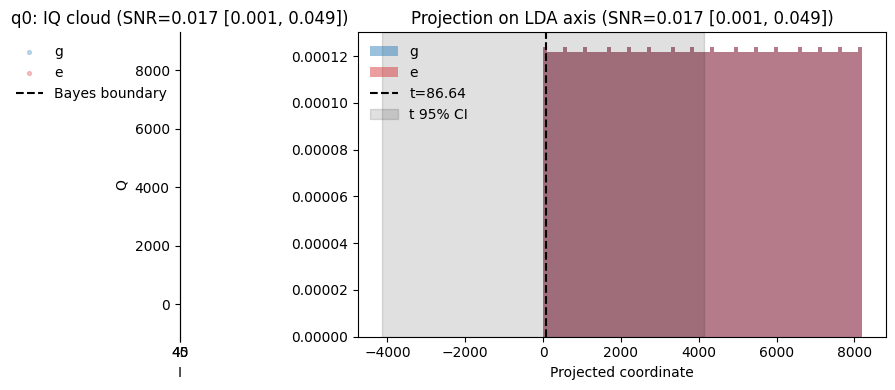

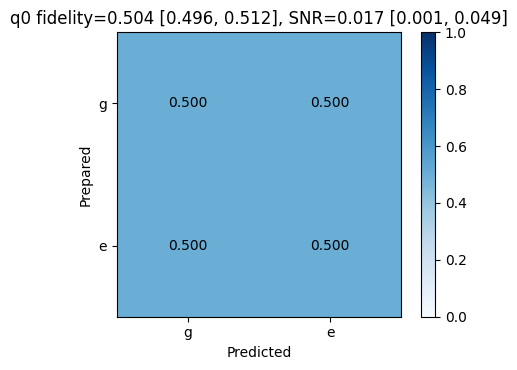

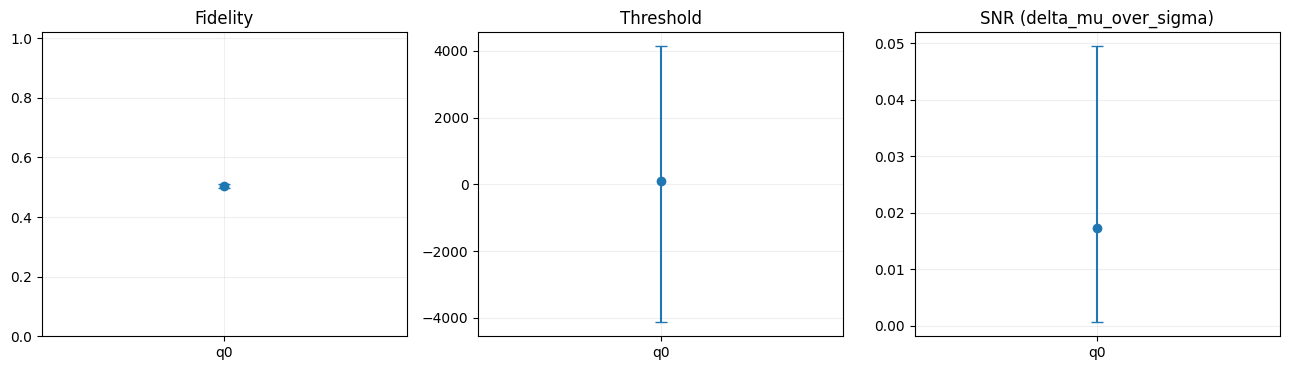

In [5]:
q0 = qubits[0]

opts_1q = iq_cloud.experiment_workflow.options()
opts_1q.do_analysis(True)
opts_1q.update(False)

wf_1q = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q0],
    options=opts_1q,
).run()

analysis_1q = extract_analysis_output(wf_1q)

print("1Q assignment fidelity:", analysis_1q["assignment_fidelity"])
print("1Q separation:", analysis_1q["separation_metrics"])
print("1Q threshold:", analysis_1q["thresholds"][q0.uid])


In [6]:
# 1Q bootstrap summary
bs_1q = analysis_1q["bootstrap"]["per_qubit"][q0.uid]
print_ci("1Q fidelity", bs_1q["fidelity"])
print_ci("1Q threshold", bs_1q["threshold"])
print_ci("1Q delta_mu_over_sigma", bs_1q["delta_mu_over_sigma"])


1Q fidelity: mean=0.5037, std=0.0040, 95% CI=[0.4965, 0.5122]
1Q threshold: mean=86.6381, std=4096.3029, 95% CI=[-4139.4027, 4140.4690]
1Q delta_mu_over_sigma: mean=0.0172, std=0.0136, 95% CI=[0.0006, 0.0495]


## 2Q Multiplexed Example


[2026.02.11 15:20:50.342] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 15:20:50.343] INFO      Workflow 'iq_cloud': execution started at 2026-02-11 06:20:50.341242Z         
[2026.02.11 15:20:50.344] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 15:20:50.349] INFO    Task 'temporary_qpu': started at 2026-02-11 06:20:50.348648Z
[2026.02.11 15:20:50.351] INFO    Task 'temporary_qpu': ended at 2026-02-11 06:20:50.351378Z
[2026.02.11 15:20:50.352] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 15:20:50.353] INFO    06:20:50.352339Z
[2026.02.11 15:20:50.354] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-11 06:20:50.353828Z
[2026.02.11 15:20:50.355] INFO    Task 'create_experiment': started at 2026-02-11 06:20:50.354929Z
[2026.02.11 15:20:50.357] INFO    Task 'create_experiment': ended at 2026-02-11 06:20:50.357088Z
[202

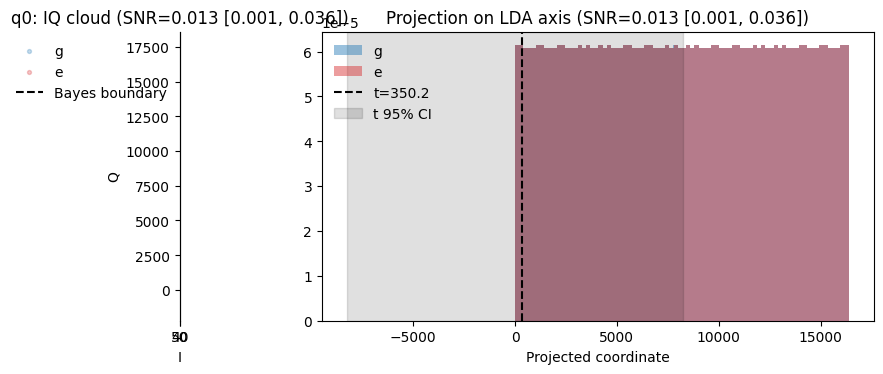

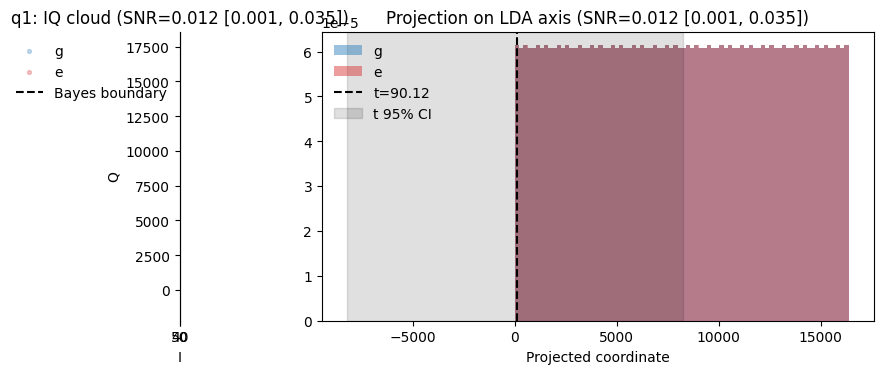

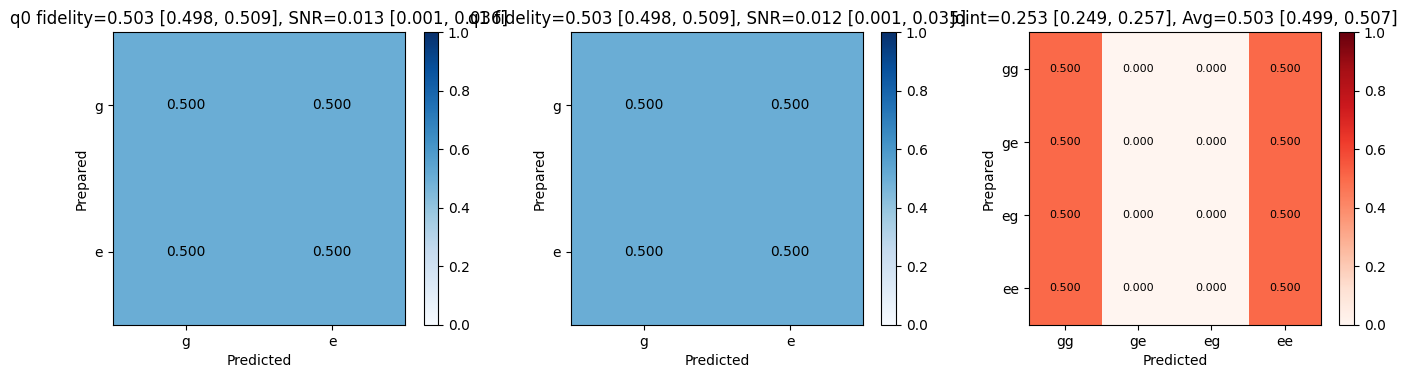

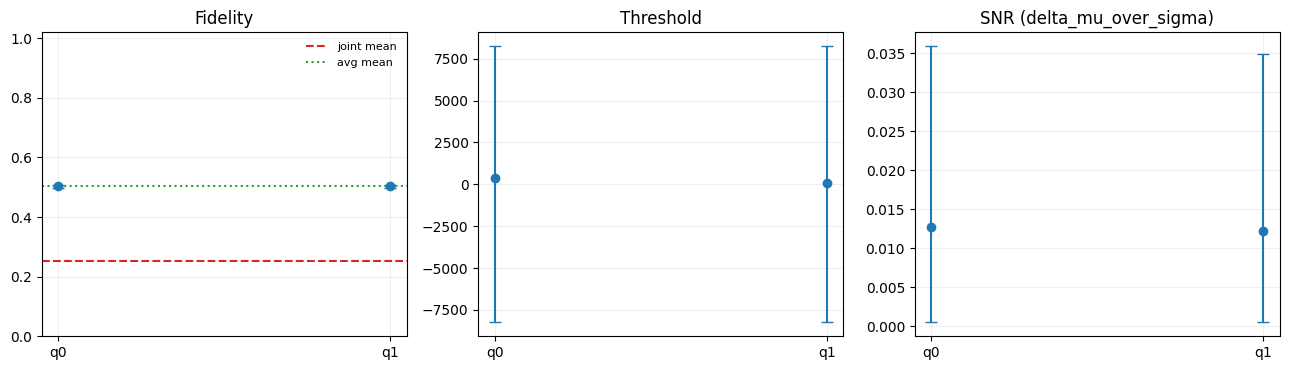

In [7]:
q0, q1 = qubits[0], qubits[1]

opts_2q = iq_cloud.experiment_workflow.options()
opts_2q.do_analysis(True)
opts_2q.update(False)

wf_2q = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q0, q1],
    options=opts_2q,
).run()

analysis_2q = extract_analysis_output(wf_2q)

print("2Q assignment fidelity:")
print(analysis_2q["assignment_fidelity"])
print()
print("2Q separation:")
print(analysis_2q["separation_metrics"])


In [8]:
# 2Q bootstrap summary
bs_2q = analysis_2q["bootstrap"]

for uid in [q0.uid, q1.uid]:
    print()
    print(f"[{uid}] bootstrap")
    print_ci("fidelity", bs_2q["per_qubit"][uid]["fidelity"])
    print_ci("threshold", bs_2q["per_qubit"][uid]["threshold"])
    print_ci("delta_mu_over_sigma", bs_2q["per_qubit"][uid]["delta_mu_over_sigma"])

print()
print("[joint]", bs_2q["joint"]["fidelity"])
print("[average]", bs_2q["average"]["fidelity"])



[q0] bootstrap
fidelity: mean=0.5028, std=0.0028, 95% CI=[0.4978, 0.5087]
threshold: mean=350.2296, std=8185.1447, 95% CI=[-8251.3945, 8247.4239]
delta_mu_over_sigma: mean=0.0127, std=0.0095, 95% CI=[0.0006, 0.0359]

[q1] bootstrap
fidelity: mean=0.5027, std=0.0028, 95% CI=[0.4979, 0.5087]
threshold: mean=90.1182, std=8192.1420, 95% CI=[-8247.6675, 8251.1083]
delta_mu_over_sigma: mean=0.0123, std=0.0094, 95% CI=[0.0005, 0.0350]

[joint] {'mean': 0.25270623779296875, 'std': 0.0020398197054042905, 'ci_low': 0.24908447265625, 'ci_high': 0.25689697265625, 'confidence_level': 0.95}
[average] {'mean': 0.5027062377929687, 'std': 0.0020398197054042905, 'ci_low': 0.49908447265625, 'ci_high': 0.50689697265625, 'confidence_level': 0.95}


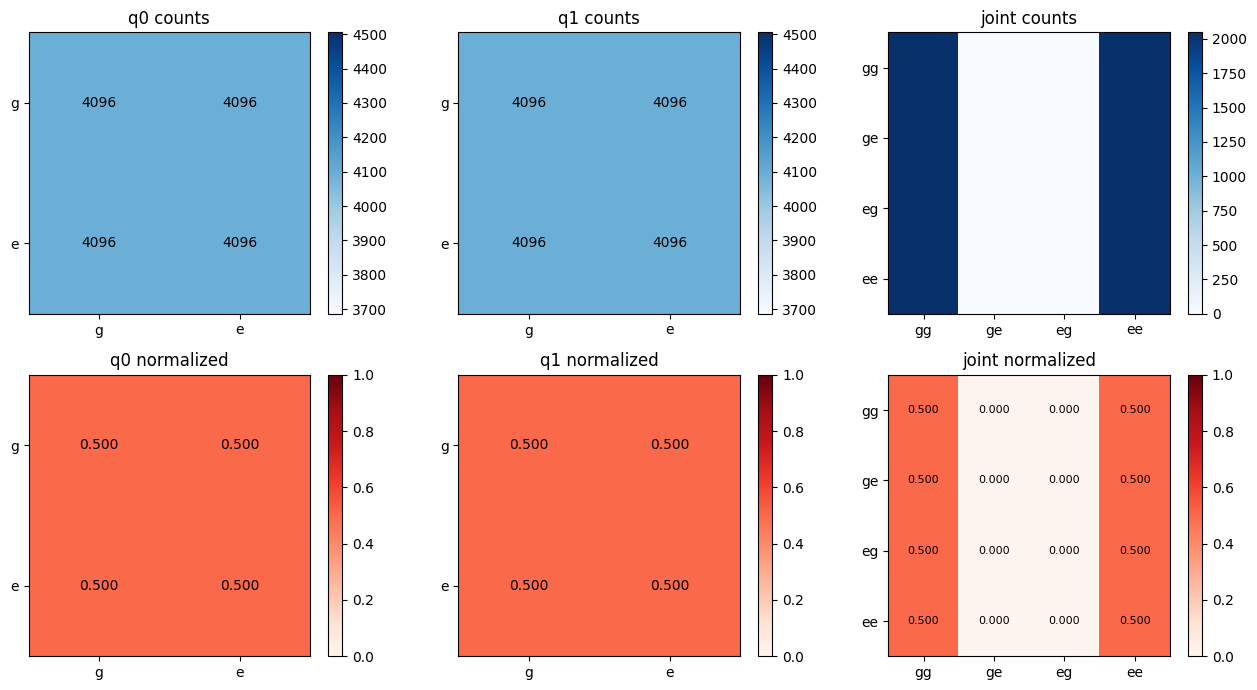

In [9]:
# Plot confusion matrices (counts + normalized)
cm = analysis_2q["confusion_matrices"]

fig, axes = plt.subplots(2, 3, figsize=(13, 7))

uids = [q0.uid, q1.uid]
for i, uid in enumerate(uids):
    c_counts = np.array(cm["per_qubit"][uid]["counts"], dtype=float)
    c_norm = np.array(cm["per_qubit"][uid]["normalized"], dtype=float)

    im0 = axes[0, i].imshow(c_counts, cmap="Blues")
    axes[0, i].set_title(f"{uid} counts")
    axes[0, i].set_xticks([0, 1], ["g", "e"])
    axes[0, i].set_yticks([0, 1], ["g", "e"])
    for r in range(2):
        for c in range(2):
            axes[0, i].text(c, r, f"{c_counts[r,c]:.0f}", ha="center", va="center")
    plt.colorbar(im0, ax=axes[0, i], fraction=0.046)

    im1 = axes[1, i].imshow(c_norm, vmin=0, vmax=1, cmap="Reds")
    axes[1, i].set_title(f"{uid} normalized")
    axes[1, i].set_xticks([0, 1], ["g", "e"])
    axes[1, i].set_yticks([0, 1], ["g", "e"])
    for r in range(2):
        for c in range(2):
            axes[1, i].text(c, r, f"{c_norm[r,c]:.3f}", ha="center", va="center")
    plt.colorbar(im1, ax=axes[1, i], fraction=0.046)

joint_counts = np.array(cm["joint"]["counts"], dtype=float)
joint_norm = np.array(cm["joint"]["normalized"], dtype=float)
labels = cm["joint"]["labels"]

im2 = axes[0, 2].imshow(joint_counts, cmap="Blues")
axes[0, 2].set_title("joint counts")
axes[0, 2].set_xticks(range(4), labels)
axes[0, 2].set_yticks(range(4), labels)
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

im3 = axes[1, 2].imshow(joint_norm, vmin=0, vmax=1, cmap="Reds")
axes[1, 2].set_title("joint normalized")
axes[1, 2].set_xticks(range(4), labels)
axes[1, 2].set_yticks(range(4), labels)
for r in range(4):
    for c in range(4):
        axes[1, 2].text(c, r, f"{joint_norm[r,c]:.3f}", ha="center", va="center", fontsize=8)
plt.colorbar(im3, ax=axes[1, 2], fraction=0.046)

plt.tight_layout()
plt.show()
        


## Optional: Apply Threshold Update to QPU

아래 셀은 분석으로 얻은 threshold를 `qpu` 파라미터에 반영합니다.
        


In [10]:
# opts_update = iq_cloud.experiment_workflow.options()
# opts_update.do_analysis(True)
# opts_update.update(True)

# _ = iq_cloud.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=[q0, q1],
#     options=opts_update,
# ).run()

# print(qpu[q0.uid].parameters.readout_integration_discrimination_thresholds)
# print(qpu[q1.uid].parameters.readout_integration_discrimination_thresholds)
        


## QuTiP Synthetic Validation (Appended)

아래 셀들은 기존 셀을 수정하지 않고 추가한 synthetic 검증 파트입니다.

검증 시나리오:
- 1Q: high-SNR / low-SNR / near-singular covariance
- 2Q: independent noise (`rho=0.0`) vs correlated noise (`rho=0.4`)
- bootstrap: 빠른 검증(500) + 최종 검증(2000)
        


In [11]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import qutip as qt
except Exception as exc:
    raise RuntimeError(
        "qutip is required for this synthetic validation block. "
        "Install qutip in the notebook kernel environment."
    ) from exc

from laboneq.dsl.result import AcquiredResult
from laboneq.workflow.tasks.run_experiment import RunExperimentResults

from qpu_types.fixed_transmon.qubit_types import (
    FixedTransmonQubit,
    FixedTransmonQubitParameters,
)
from experiments.iq_cloud_common import (
    iq_cloud_handle,
    prepared_labels_for_num_qubits,
)
from analysis import iq_cloud as iq_cloud_analysis


def make_test_qubit(uid='q0', f_lo=7.0e9, f_res=7.05e9):
    return FixedTransmonQubit(
        uid=uid,
        signals={
            'acquire': f'{uid}/acquire',
            'drive': f'{uid}/drive',
            'measure': f'{uid}/measure',
        },
        parameters=FixedTransmonQubitParameters(
            readout_lo_frequency=f_lo,
            readout_resonator_frequency=f_res,
        ),
    )


def qutip_pointer_mean(
    state: str,
    kappa_hz: float = 25e6,
    chi_hz: float = 2.5e6,
    drive_hz: float = 35e6,
    length_ns: float = 1000.0,
    dt_ns: float = 2.0,
    phase_rad: float = 0.0,
    N: int = 30,
):
    """Return synthetic integrated IQ mean from a damped driven cavity model."""
    a = qt.destroy(N)
    psi0 = qt.basis(N, 0)

    # Use angular frequencies in rad/s.
    two_pi = 2.0 * np.pi
    kappa = two_pi * kappa_hz
    chi = two_pi * chi_hz
    eps = two_pi * drive_hz

    state_shift = {'g': -0.5 * chi, 'e': 0.5 * chi}[state]
    H0 = state_shift * (a.dag() * a)
    Hd = a + a.dag()

    t_ns = np.arange(0.0, length_ns, dt_ns)
    tlist = t_ns * 1e-9

    # Constant readout drive during acquisition window.
    out = qt.mesolve(
        [H0, [Hd, lambda _t, _args=None: eps]],
        psi0,
        tlist,
        [np.sqrt(kappa) * a],
        [a],
        options={'progress_bar': False},
    )
    alpha_t = np.asarray(out.expect[0], dtype=complex)

    # Use tail average as integrated mean IQ.
    tail = max(8, len(alpha_t) // 5)
    mean_complex = np.mean(alpha_t[-tail:]) * np.exp(1j * phase_rad)
    return complex(mean_complex)


def make_synthetic_iq_cloud_result(
    qubits,
    n_shots=4000,
    seed=0,
    noise_sigma=0.08,
    imag_noise_scale=1.0,
    rho=0.0,
    kappa_hz=25e6,
    chis_hz=None,
    drives_hz=None,
    phases_rad=None,
):
    """Create synthetic integrated-IQ RunExperimentResults for iq_cloud handles."""
    qubits = list(qubits)
    num_qubits = len(qubits)
    labels = prepared_labels_for_num_qubits(num_qubits)

    if chis_hz is None:
        chis_hz = [2.5e6 + 0.5e6 * i for i in range(num_qubits)]
    if drives_hz is None:
        drives_hz = [35e6 + 3e6 * i for i in range(num_qubits)]
    if phases_rad is None:
        phases_rad = [0.2 + 0.6 * i for i in range(num_qubits)]

    rng = np.random.default_rng(seed)

    means = {q.uid: {} for q in qubits}
    for i, q in enumerate(qubits):
        means[q.uid]['g'] = qutip_pointer_mean(
            'g',
            kappa_hz=kappa_hz,
            chi_hz=chis_hz[i],
            drive_hz=drives_hz[i],
            phase_rad=phases_rad[i],
        )
        means[q.uid]['e'] = qutip_pointer_mean(
            'e',
            kappa_hz=kappa_hz,
            chi_hz=chis_hz[i],
            drive_hz=drives_hz[i],
            phase_rad=phases_rad[i],
        )

    acquired = {}

    for label in labels:
        if num_qubits == 1:
            q = qubits[0]
            state = label
            mu = means[q.uid][state]
            noise = noise_sigma * (
                rng.normal(size=n_shots) + 1j * imag_noise_scale * rng.normal(size=n_shots)
            )
            shots = mu + noise
            acquired[iq_cloud_handle(q.uid, label)] = AcquiredResult(
                data=shots,
                axis_name=['shots'],
                axis=[np.arange(n_shots)],
            )
        else:
            q0, q1 = qubits
            s0, s1 = label[0], label[1]
            mu0 = means[q0.uid][s0]
            mu1 = means[q1.uid][s1]

            # Correlated complex noise for stress test (rho=0 -> independent).
            u0 = rng.normal(size=n_shots)
            v0 = rng.normal(size=n_shots)
            u1 = rng.normal(size=n_shots)
            v1 = rng.normal(size=n_shots)

            rho_clip = float(np.clip(rho, -0.999, 0.999))
            c = np.sqrt(1.0 - rho_clip**2)

            n0 = noise_sigma * (u0 + 1j * imag_noise_scale * v0)
            n1 = noise_sigma * (
                (rho_clip * u0 + c * u1)
                + 1j * imag_noise_scale * (rho_clip * v0 + c * v1)
            )

            shots0 = mu0 + n0
            shots1 = mu1 + n1

            acquired[iq_cloud_handle(q0.uid, label)] = AcquiredResult(
                data=shots0,
                axis_name=['shots'],
                axis=[np.arange(n_shots)],
            )
            acquired[iq_cloud_handle(q1.uid, label)] = AcquiredResult(
                data=shots1,
                axis_name=['shots'],
                axis=[np.arange(n_shots)],
            )

    return RunExperimentResults(acquired_results=acquired), means


def run_iq_cloud_analysis_from_result(
    result,
    qubits,
    ridge_target_condition=1e6,
    bootstrap_samples=500,
    bootstrap_seed=123,
    do_plotting=False,
    show_plots=True,
):
    """Run iq_cloud analysis task-by-task for synthetic validation.

    If do_plotting=True, call iq_cloud plot tasks and optionally display figures.
    """
    processed = iq_cloud_analysis.collect_shots(qubits=qubits, result=result)
    model = iq_cloud_analysis.fit_decision_models(
        processed_data=processed,
        qubits=qubits,
        ridge_target_condition=ridge_target_condition,
    )
    thresholds = iq_cloud_analysis.extract_thresholds(model)
    assignment_bundle = iq_cloud_analysis.calculate_confusion_and_fidelity(
        processed_data=processed,
        decision_model=model,
        qubits=qubits,
    )
    confusion = iq_cloud_analysis.select_confusion_matrices(assignment_bundle)
    fidelity = iq_cloud_analysis.select_assignment_fidelity(assignment_bundle)
    separation = iq_cloud_analysis.calculate_separation_metrics(model)
    bootstrap = iq_cloud_analysis.bootstrap_metrics(
        processed_data=processed,
        qubits=qubits,
        ridge_target_condition=ridge_target_condition,
        bootstrap_samples=bootstrap_samples,
        bootstrap_confidence_level=0.95,
        bootstrap_seed=bootstrap_seed,
    )

    figures = None
    if do_plotting:
        fig_iq = iq_cloud_analysis.plot_iq_clouds(
            processed_data=processed,
            decision_model=model,
            qubits=qubits,
            bootstrap=bootstrap,
        )
        fig_assign = iq_cloud_analysis.plot_assignment_matrices(
            confusion_matrices=confusion,
            assignment_fidelity=fidelity,
            qubits=qubits,
            separation_metrics=separation,
        )
        fig_boot = iq_cloud_analysis.plot_bootstrap_summary(
            bootstrap=bootstrap,
            qubits=qubits,
        )
        figures = {
            'iq_clouds': fig_iq,
            'assignment_matrices': fig_assign,
            'bootstrap_summary': fig_boot,
        }
        if show_plots:
            plt.show()

    return {
        'processed': processed,
        'decision_model': model,
        'thresholds': thresholds,
        'confusion_matrices': confusion,
        'assignment_fidelity': fidelity,
        'separation_metrics': separation,
        'bootstrap': bootstrap,
        'figures': figures,
    }


def summarize_per_qubit_metrics(tag, out, uid):
    fid = out['assignment_fidelity']['per_qubit'][uid]
    sep = out['separation_metrics']['per_qubit'][uid]
    print(
        f"[{tag}] {uid}: fidelity={fid:.4f}, "
        f"delta_mu_over_sigma={sep['delta_mu_over_sigma']:.4f}"
    )
        


In [12]:
# 1Q validation cases: high-SNR / low-SNR / near-singular
syn_q0 = make_test_qubit('syn_q0', f_lo=7.0e9, f_res=7.05e9)

res_1q_high, means_1q_high = make_synthetic_iq_cloud_result(
    qubits=[syn_q0],
    n_shots=5000,
    seed=11,
    noise_sigma=0.12,
    imag_noise_scale=1.0,
)
out_1q_high = run_iq_cloud_analysis_from_result(
    result=res_1q_high,
    qubits=[syn_q0],
    bootstrap_samples=500,
    bootstrap_seed=211,
)

res_1q_low, means_1q_low = make_synthetic_iq_cloud_result(
    qubits=[syn_q0],
    n_shots=5000,
    seed=12,
    noise_sigma=0.2,
    imag_noise_scale=1.0,
)
out_1q_low = run_iq_cloud_analysis_from_result(
    result=res_1q_low,
    qubits=[syn_q0],
    bootstrap_samples=500,
    bootstrap_seed=212,
)

res_1q_sing, means_1q_sing = make_synthetic_iq_cloud_result(
    qubits=[syn_q0],
    n_shots=5000,
    seed=13,
    noise_sigma=0.05,
    imag_noise_scale=0.02,  # nearly singular covariance
)
out_1q_sing = run_iq_cloud_analysis_from_result(
    result=res_1q_sing,
    qubits=[syn_q0],
    bootstrap_samples=500,
    bootstrap_seed=213,
)

summarize_per_qubit_metrics('1Q-high', out_1q_high, syn_q0.uid)
summarize_per_qubit_metrics('1Q-low', out_1q_low, syn_q0.uid)
summarize_per_qubit_metrics('1Q-sing', out_1q_sing, syn_q0.uid)

print()
print('Ridge alpha check (singular case):', out_1q_sing['decision_model'][syn_q0.uid]['ridge_alpha'])
        


[1Q-high] syn_q0: fidelity=0.9887, delta_mu_over_sigma=4.6283
[1Q-low] syn_q0: fidelity=0.9199, delta_mu_over_sigma=2.7878
[1Q-sing] syn_q0: fidelity=1.0000, delta_mu_over_sigma=110.9868

Ridge alpha check (singular case): 0.0


In [18]:
# # 1Q trend check and quick visualization
# fid_high = out_1q_high['assignment_fidelity']['per_qubit'][syn_q0.uid]
# fid_low = out_1q_low['assignment_fidelity']['per_qubit'][syn_q0.uid]
# sep_high = out_1q_high['separation_metrics']['per_qubit'][syn_q0.uid]['delta_mu_over_sigma']
# sep_low = out_1q_low['separation_metrics']['per_qubit'][syn_q0.uid]['delta_mu_over_sigma']

# print('expected trend: high-SNR > low-SNR')
# print('fidelity high/low:', fid_high, fid_low)
# print('delta_mu_over_sigma high/low:', sep_high, sep_low)

# assert fid_high > fid_low, 'Unexpected trend: high-SNR fidelity should be larger.'
# assert sep_high > sep_low, 'Unexpected trend: high-SNR separation should be larger.'

# labels = ['high', 'low', 'near-sing']
# fids = [
#     out_1q_high['assignment_fidelity']['per_qubit'][syn_q0.uid],
#     out_1q_low['assignment_fidelity']['per_qubit'][syn_q0.uid],
#     out_1q_sing['assignment_fidelity']['per_qubit'][syn_q0.uid],
# ]
# seps = [
#     out_1q_high['separation_metrics']['per_qubit'][syn_q0.uid]['delta_mu_over_sigma'],
#     out_1q_low['separation_metrics']['per_qubit'][syn_q0.uid]['delta_mu_over_sigma'],
#     out_1q_sing['separation_metrics']['per_qubit'][syn_q0.uid]['delta_mu_over_sigma'],
# ]

# fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
# axes[0].bar(labels, fids, color=['tab:green', 'tab:orange', 'tab:blue'])
# axes[0].set_title('1Q fidelity')
# axes[0].set_ylim(0, 1)
# axes[1].bar(labels, seps, color=['tab:green', 'tab:orange', 'tab:blue'])
# axes[1].set_title('1Q delta_mu_over_sigma')
# plt.tight_layout()
# plt.show()
        


In [14]:
# 2Q multiplexed validation: independent (rho=0) vs correlated (rho=0.4)
syn_q0_2 = make_test_qubit('syn_q0_2', f_lo=7.0e9, f_res=7.05e9)
syn_q1_2 = make_test_qubit('syn_q1_2', f_lo=7.2e9, f_res=7.25e9)

res_2q_ind, means_2q_ind = make_synthetic_iq_cloud_result(
    qubits=[syn_q0_2, syn_q1_2],
    n_shots=6000,
    seed=21,
    noise_sigma=0.06,
    imag_noise_scale=1.0,
    rho=0.0,
)
out_2q_ind = run_iq_cloud_analysis_from_result(
    result=res_2q_ind,
    qubits=[syn_q0_2, syn_q1_2],
    bootstrap_samples=500,
    bootstrap_seed=221,
)

res_2q_corr, means_2q_corr = make_synthetic_iq_cloud_result(
    qubits=[syn_q0_2, syn_q1_2],
    n_shots=6000,
    seed=22,
    noise_sigma=0.06,
    imag_noise_scale=1.0,
    rho=0.4,
)
out_2q_corr = run_iq_cloud_analysis_from_result(
    result=res_2q_corr,
    qubits=[syn_q0_2, syn_q1_2],
    bootstrap_samples=500,
    bootstrap_seed=222,
)

print('2Q independent fidelity:', out_2q_ind['assignment_fidelity'])
print('2Q correlated fidelity:', out_2q_corr['assignment_fidelity'])

for uid in [syn_q0_2.uid, syn_q1_2.uid]:
    summarize_per_qubit_metrics('2Q-ind', out_2q_ind, uid)
    summarize_per_qubit_metrics('2Q-corr', out_2q_corr, uid)
        


2Q independent fidelity: {'per_qubit': {'syn_q0_2': 1.0, 'syn_q1_2': 1.0}, 'joint': 1.0, 'average': 1.0}
2Q correlated fidelity: {'per_qubit': {'syn_q0_2': 1.0, 'syn_q1_2': 1.0}, 'joint': 1.0, 'average': 1.0}
[2Q-ind] syn_q0_2: fidelity=1.0000, delta_mu_over_sigma=9.3063
[2Q-corr] syn_q0_2: fidelity=1.0000, delta_mu_over_sigma=9.3257
[2Q-ind] syn_q1_2: fidelity=1.0000, delta_mu_over_sigma=12.0543
[2Q-corr] syn_q1_2: fidelity=1.0000, delta_mu_over_sigma=12.0508


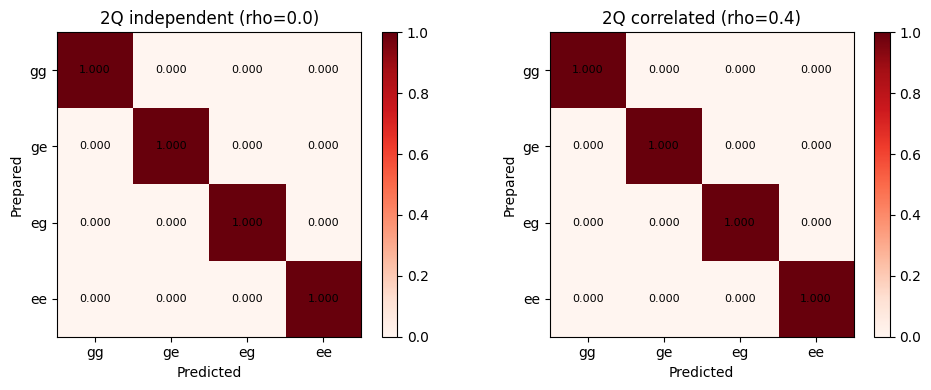

In [15]:
# Compare 2Q joint confusion matrices (normalized)
cm_ind = np.asarray(out_2q_ind['confusion_matrices']['joint']['normalized'])
cm_corr = np.asarray(out_2q_corr['confusion_matrices']['joint']['normalized'])
labels = out_2q_ind['confusion_matrices']['joint']['labels']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, mat, title in [
    (axes[0], cm_ind, '2Q independent (rho=0.0)'),
    (axes[1], cm_corr, '2Q correlated (rho=0.4)'),
]:
    im = ax.imshow(mat, vmin=0, vmax=1, cmap='Reds')
    ax.set_title(title)
    ax.set_xticks(range(4), labels)
    ax.set_yticks(range(4), labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Prepared')
    for r in range(4):
        for c in range(4):
            ax.text(c, r, f'{mat[r,c]:.3f}', ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()
        


In [16]:
# Final bootstrap check with 2000 samples (recommended final confidence run)
out_2q_corr_bs2000 = run_iq_cloud_analysis_from_result(
    result=res_2q_corr,
    qubits=[syn_q0_2, syn_q1_2],
    bootstrap_samples=2000,
    bootstrap_seed=2026,
)

print('bootstrap settings:', out_2q_corr_bs2000['bootstrap']['settings'])
print('joint fidelity CI (rho=0.4, B=2000):')
print(out_2q_corr_bs2000['bootstrap']['joint']['fidelity'])

for uid in [syn_q0_2.uid, syn_q1_2.uid]:
    print(f'[{uid}] threshold CI:', out_2q_corr_bs2000['bootstrap']['per_qubit'][uid]['threshold'])
    print(f'[{uid}] delta_mu_over_sigma CI:', out_2q_corr_bs2000['bootstrap']['per_qubit'][uid]['delta_mu_over_sigma'])
        


bootstrap settings: {'bootstrap_samples': 2000, 'confidence_level': 0.95, 'seed': 2026}
joint fidelity CI (rho=0.4, B=2000):
{'mean': 1.0, 'std': 0.0, 'ci_low': 1.0, 'ci_high': 1.0, 'confidence_level': 0.95}
[syn_q0_2] threshold CI: {'mean': -0.0034867058918109646, 'std': 0.018317757620298247, 'ci_low': -0.039280776351264875, 'ci_high': 0.03233330968103553, 'confidence_level': 0.95}
[syn_q0_2] delta_mu_over_sigma CI: {'mean': 9.328233485295762, 'std': 0.0466397934090765, 'ci_low': 9.238219401740055, 'ci_high': 9.422067407066729, 'confidence_level': 0.95}
[syn_q1_2] threshold CI: {'mean': -0.0012838838236402656, 'std': 0.018844195249385583, 'ci_low': -0.03833088001201977, 'ci_high': 0.03627014679433033, 'confidence_level': 0.95}
[syn_q1_2] delta_mu_over_sigma CI: {'mean': 12.052130534952779, 'std': 0.05476641112441259, 'ci_low': 11.940827999001458, 'ci_high': 12.162958094678878, 'confidence_level': 0.95}



=== 1Q-high ===


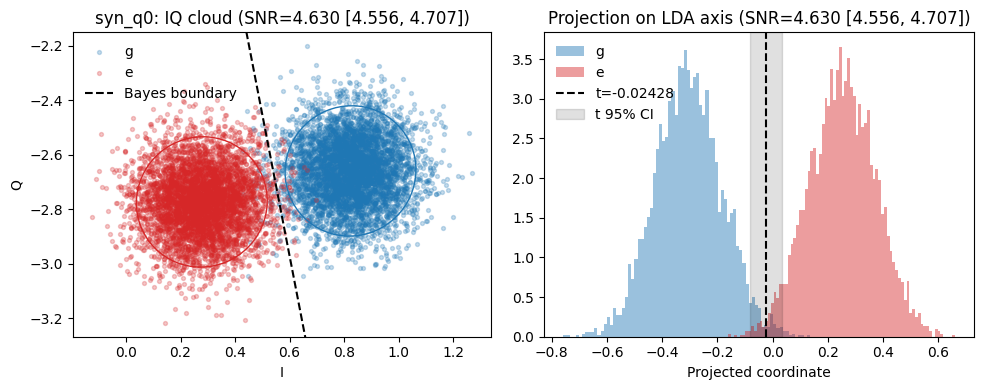

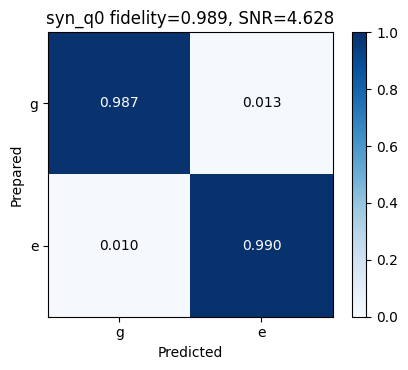

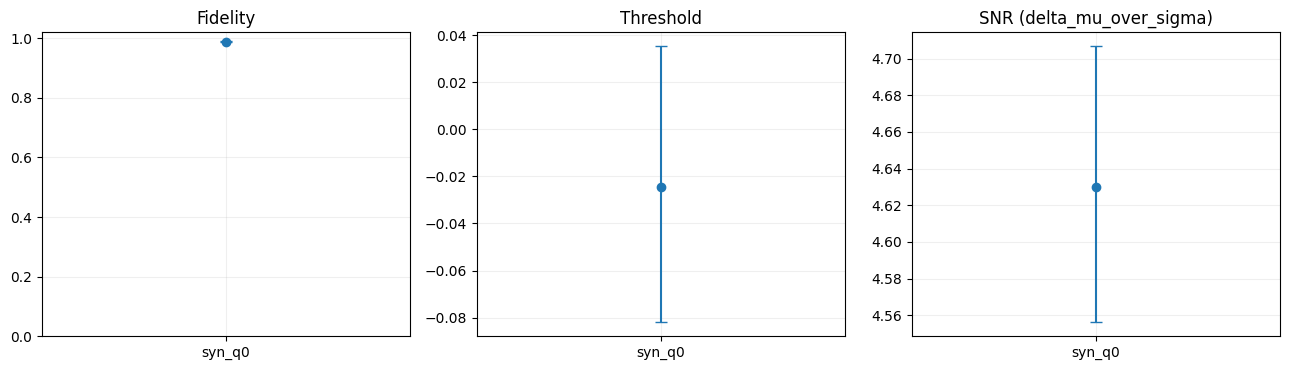


=== 1Q-low ===


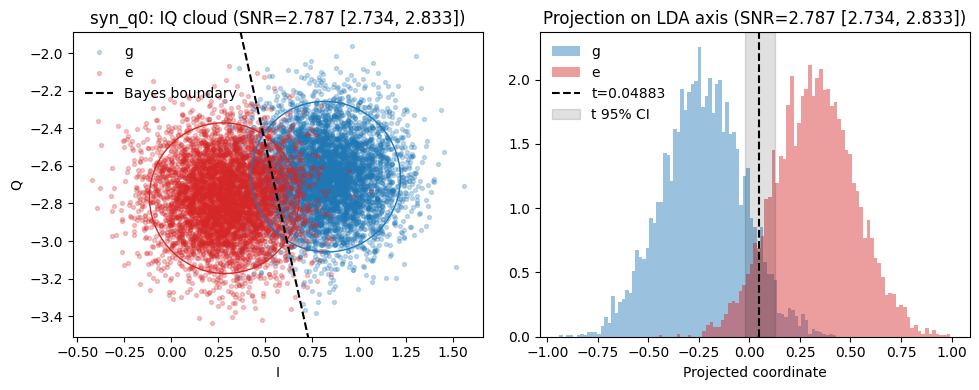

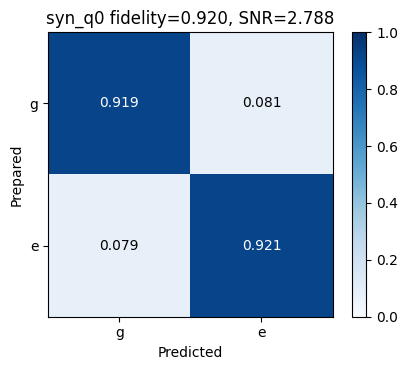

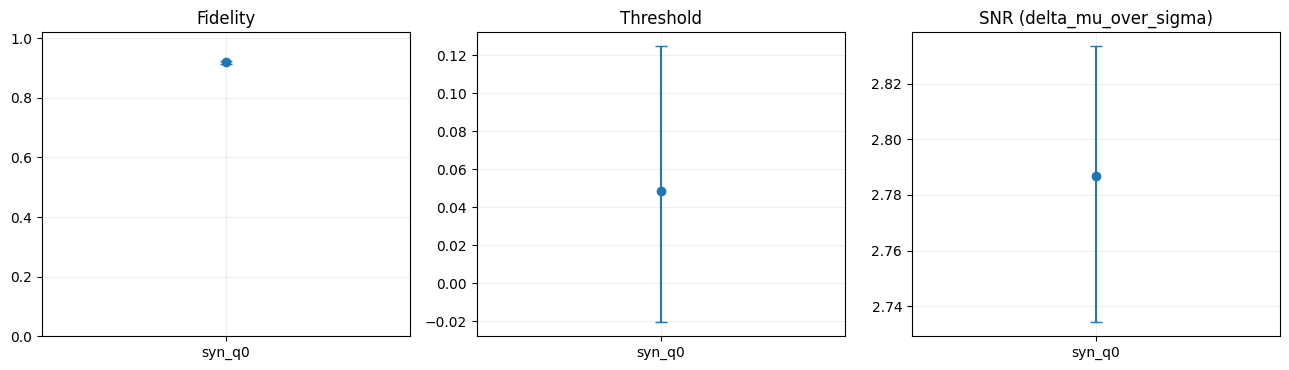


=== 1Q-near-singular ===


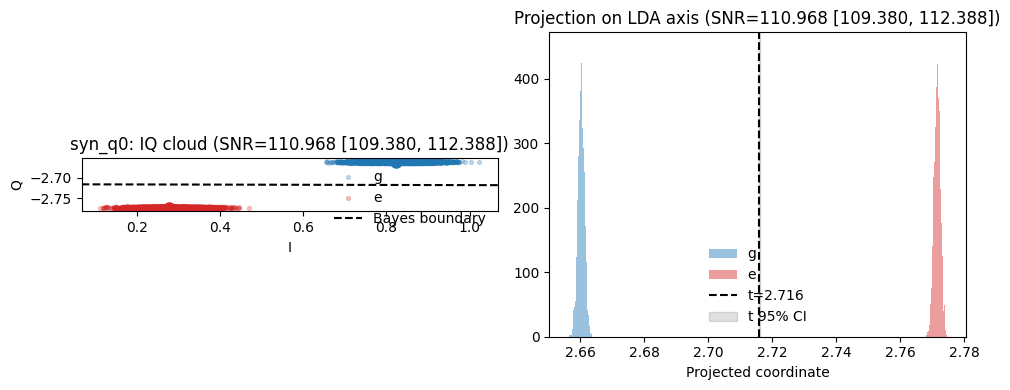

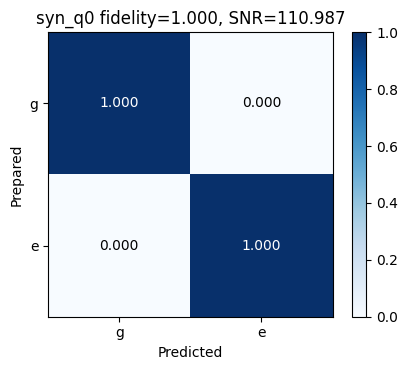

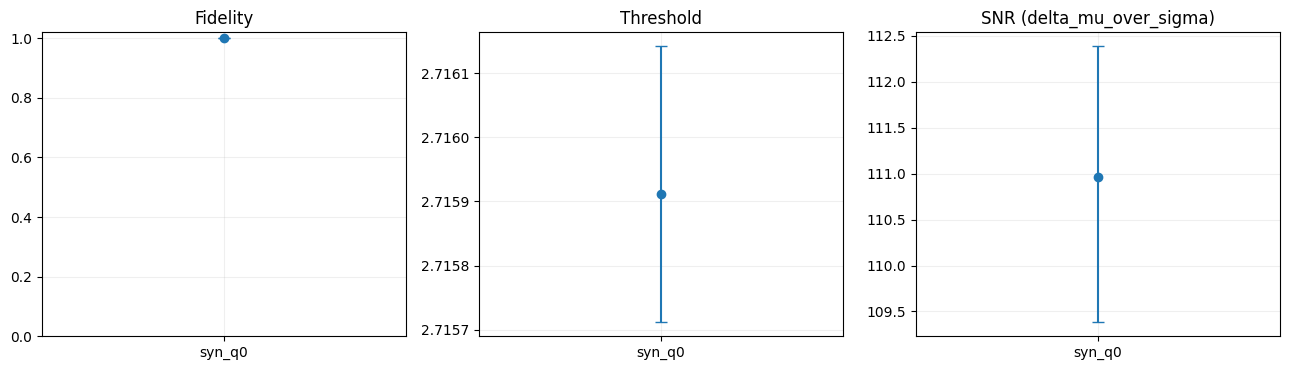

In [17]:
# Plot helper: visualize analysis plots from existing synthetic outputs

# 1Q: high/low/near-singular all visualization
for tag, res_obj, seed in [
    ("1Q-high", res_1q_high, 310),
    ("1Q-low", res_1q_low, 311),
    ("1Q-near-singular", res_1q_sing, 312),
]:
    print(f"\n=== {tag} ===")
    _ = run_iq_cloud_analysis_from_result(
        result=res_obj,
        qubits=[syn_q0],
        bootstrap_samples=200,
        bootstrap_seed=seed,
        do_plotting=True,
        show_plots=True,
    )

# # 2Q correlated case visualization
# print("\n=== 2Q-correlated (rho=0.4) ===")
# _ = run_iq_cloud_analysis_from_result(
#     result=res_2q_corr,
#     qubits=[syn_q0_2, syn_q1_2],
#     bootstrap_samples=200,
#     bootstrap_seed=313,
#     do_plotting=True,
#     show_plots=True,
# )
